In [1]:
import glob

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
from torch.nn import functional as F
from transformers import AutoTokenizer

# import os
# import openai
# from dotenv import load_dotenv

In [2]:
model_names = [
    "pythia-70m",
    "pythia-160m",
    "pythia-410m",
    "pythia-1b",
    "pythia-1.4b",
    "pythia-2.8b",
    "pythia-6.9b",
    "pythia-12b",
]

In [3]:
model_name = model_names[5]
step = 143000

tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir="/tmp/"
)

embeddings = torch.load(f"pythia-embeddings/{model_name}_embeddings.pt")

In [4]:
model_name

'pythia-2.8b'

In [5]:
def alternates(word):
    mutations = [
        word,
        word.capitalize(),
        word.upper(),
        " " + word,
        " " + word.capitalize(),
        " " + word.upper(),
        # remove spaces
        word.replace(" ", ""),
        word.replace(" ", "").capitalize(),
        word.replace(" ", "").upper(),
        " " + word.replace(" ", ""),
        " " + word.replace(" ", "").capitalize(),
        " " + word.replace(" ", "").upper(),
    ]
    return list(set(mutations))

def alternate_tokens(word, tokenizer):
    return {
        tokenizer.encode(mutation, add_special_tokens=False)[0]: mutation
        for mutation in alternates(word) 
        if len(tokenizer.encode(mutation, add_special_tokens=False)) == 1
    }

def get_closest_tokens_euclidean(embedding, embeddings, tokenizer, topk=10):
    # Calculate distances.
    distances = torch.norm(embeddings - embedding, dim=1)
    # Get the top k smallest distances.
    sims, indices = torch.topk(distances, topk, largest=False)
    
    # Decode the token IDs to tokens.
    closest_tokens = [tokenizer.decode([token_id]) for token_id in indices]
    return {
        sims[i].item(): closest_tokens[i]
        for i in range(len(closest_tokens))
    }

def get_closest_tokens_cosine(embedding, embeddings, tokenizer, topk=10):
    # Calculate similarities. We use cosine similarity here.
    similarities = F.cosine_similarity(embedding.unsqueeze(0), embeddings)
    # Get the top k indices.
    sims, indices = torch.topk(similarities, topk)
    
    # Decode the token IDs to tokens.
    closest_tokens = [tokenizer.decode([token_id]) for token_id in indices]
    return {
        sims[i].item(): closest_tokens[i]
        for i in range(len(closest_tokens))
    }

In [6]:
alternate_tokens(" cat", tokenizer)

{5798: ' cat',
 29782: ' CAT',
 12441: ' Cat',
 8076: 'cat',
 23475: 'Cat',
 24227: 'CAT'}

In [7]:
token_and_capitalized = []
for i in tqdm(range(tokenizer.vocab_size)):
    token = tokenizer.decode([i])
    if token[0] == " ":
        alts = alternate_tokens(token, tokenizer)
        for token_id, alternate in alts.items():
            if (token[1:].capitalize() != token[1:]) and (token[1:].capitalize() == alternate[1:]):
                token_and_capitalized.append((i, token_id))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/50254 [00:00<?, ?it/s]

In [8]:
for token_id, alternate_id in token_and_capitalized[1000:1010]:
    print(tokenizer.decode([token_id]), tokenizer.decode([alternate_id]))

 pain  Pain
 bad  Bad
 additional  Additional
 methods  Methods
 inhib  Inhib
 film  Film
 shall  Shall
 introdu  Introdu
 someone  Someone
 eff  Eff


In [9]:
len(token_and_capitalized)

5187

In [10]:
# compute mean difference between embeddings
with torch.no_grad():
    sum_diff = torch.zeros(embeddings.shape[1])
    for token_id, capitalized_id in tqdm(token_and_capitalized):
        sum_diff += embeddings[capitalized_id] - embeddings[token_id]
    mean_diff = sum_diff / len(token_and_capitalized)

  0%|          | 0/5187 [00:00<?, ?it/s]

In [11]:
token_id, capitalized_id = token_and_capitalized[1001]
print(tokenizer.decode([token_id]), "->", tokenizer.decode([capitalized_id]))
get_closest_tokens_euclidean(embeddings[token_id] + mean_diff, embeddings, tokenizer)

 bad ->  Bad


{0.1477002650499344: ' bad',
 0.9206334352493286: ' Bad',
 0.920967698097229: 'Bad',
 0.9425021409988403: 'bad',
 1.0163201093673706: '                                                                              ',
 1.0173985958099365: '                       ',
 1.0175917148590088: '                                  ',
 1.0182493925094604: '\n\n\n   ',
 1.019283652305603: '\n\t   ',
 1.019506812095642: ''}

In [12]:
get_closest_tokens_euclidean(embeddings[token_id], embeddings, tokenizer)

{0.0: ' bad',
 0.9353898763656616: 'Bad',
 0.9411768913269043: ' Bad',
 0.9416683316230774: 'bad',
 1.0187368392944336: '                                                                              ',
 1.0198696851730347: '                       ',
 1.020439863204956: '                                  ',
 1.021166443824768: '\n\n\n   ',
 1.0212761163711548: '\n\t   ',
 1.0218368768692017: '\n                 '}

In [72]:
token_id, capitalized_id = token_and_capitalized[2000]
print(tokenizer.decode([token_id]), "->", tokenizer.decode([capitalized_id]))
get_closest_tokens_euclidean(embeddings[token_id] + mean_diff, embeddings, tokenizer)

 external ->  External


{0.1477002650499344: ' external',
 0.8215364813804626: ' External',
 0.9581328630447388: 'external',
 0.9819112420082092: ' externally',
 1.0182443857192993: '\r\n\r\n       ',
 1.018649935722351: '                                                                                                ',
 1.0214980840682983: '',
 1.0236022472381592: '                                                                      ',
 1.0236583948135376: '\n\t  ',
 1.0237714052200317: '              \n '}

In [73]:
get_closest_tokens_euclidean(embeddings[token_id], embeddings, tokenizer)

{0.0: ' external',
 0.8367446660995483: ' External',
 0.9570862650871277: 'external',
 0.9770315289497375: ' externally',
 1.0178085565567017: '                                                                                                ',
 1.0180479288101196: '\r\n\r\n       ',
 1.020216703414917: '',
 1.0222201347351074: '                                                                      ',
 1.022477388381958: '\n\t  ',
 1.0228482484817505: '\n            \n           '}

In [107]:
# perform PCA on 2 token_and_embedding pairs of embeddings
# perform a PCA on 2N of the embeddings
with torch.no_grad():
    N = 2000
    embeddings_pairs = torch.zeros((2*N, embeddings.shape[1]))
    for i, (token_id, captalized_id) in enumerate(token_and_capitalized[1000:1000+N]):
        embeddings_pairs[2*i] = embeddings[token_id]
        embeddings_pairs[2*i+1] = embeddings[capitalized_id]
    embeddings_pairs = embeddings_pairs.numpy()

In [108]:
embeddings_pairs.shape

(4000, 2560)

In [109]:
pca = PCA(n_components=10)
pca.fit(embeddings_pairs)

PCA(n_components=10)

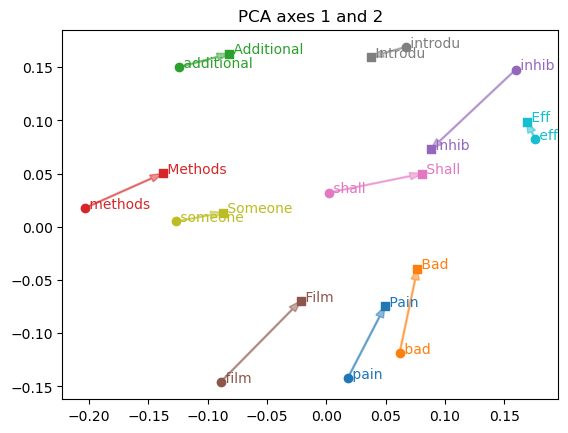

In [119]:
i0, i1 = 1, 2
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'] # (C0, C1, ...)
with torch.no_grad():
    for i, (token_id, capitalized_id) in enumerate(token_and_capitalized[1000:1010]):
        token = tokenizer.decode([token_id])
        capitalized = tokenizer.decode([capitalized_id])
        token_embedding = pca.transform(embeddings[token_id].unsqueeze(0))[0]
        capitalized_embedding = pca.transform(embeddings[capitalized_id].unsqueeze(0))[0]
        plt.scatter(token_embedding[i0], token_embedding[i1], c=colors[i%10], marker='o')
        plt.annotate(token, (token_embedding[i0], token_embedding[i1]), c=colors[i%10])
        plt.scatter(capitalized_embedding[i0], capitalized_embedding[i1], c=colors[i%10], marker='s')
        plt.annotate(capitalized, (capitalized_embedding[i0], capitalized_embedding[i1]), c=colors[i%10])
        plt.arrow(token_embedding[i0], token_embedding[i1], 
                capitalized_embedding[i0] - token_embedding[i0], 
                capitalized_embedding[i1] - token_embedding[i1], 
                length_includes_head=True,
                head_width=0.007,
                color=colors[i%10], alpha=0.5)
        plt.title("PCA axes {} and {}".format(i0, i1))

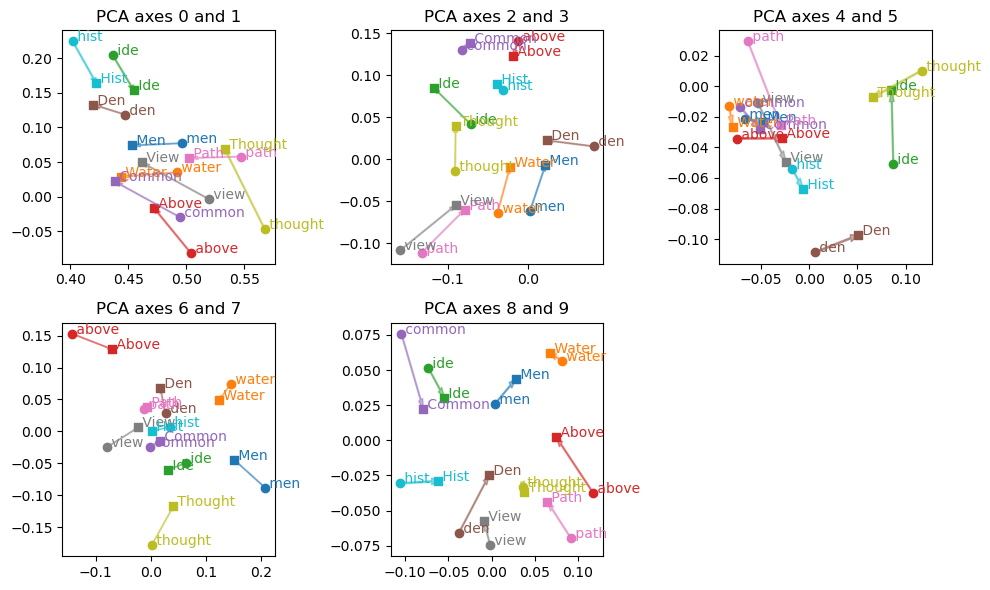

In [ ]:
plt.figure(figsize=(10, 6))
i01s = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
for k, (i0, i1) in enumerate(i01s):
    plt.subplot(2, 3, k+1)
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'] # (C0, C1, ...)
    with torch.no_grad():
        for i, (token_id, capitalized_id) in enumerate(definitely_word_pairs[400:410]):
            token = tokenizer.decode([token_id])
            capitalized = tokenizer.decode([capitalized_id])
            token_embedding = pca.transform(embeddings[token_id].unsqueeze(0))[0]
            capitalized_embedding = pca.transform(embeddings[capitalized_id].unsqueeze(0))[0]
            plt.scatter(token_embedding[i0], token_embedding[i1], c=colors[i%10], marker='o')
            plt.annotate(token, (token_embedding[i0], token_embedding[i1]), c=colors[i%10])
            plt.scatter(capitalized_embedding[i0], capitalized_embedding[i1], c=colors[i%10], marker='s')
            plt.annotate(capitalized, (capitalized_embedding[i0], capitalized_embedding[i1]), c=colors[i%10])
            plt.arrow(token_embedding[i0], token_embedding[i1], 
                    capitalized_embedding[i0] - token_embedding[i0], 
                    capitalized_embedding[i1] - token_embedding[i1], 
                    length_includes_head=True,
                    head_width=0.005,
                    color=colors[i%10], alpha=0.5)
            plt.title("PCA axes {} and {}".format(i0, i1))
plt.tight_layout()

In [13]:
# find the subset that correspond to full words

# load_dotenv(".env")
# openai.organization = "org-rb3uAmeJTUiV7z79cRW16mKX"
# openai.api_key = os.getenv("OPENAI_API_KEY")

# prompt = f"""Label the given token as either a full word or a subword. Answer "full" or "subword" only. Continue the examples shown.
# Token: "cat", Label: full
# Token: " Paris", Label: full
# Token: "ing", Label: subword
# Token: " Ch", Label: subword
# Token: "{' pasta'}", Label:"""
# completion = openai.Completion.create(
#     model="text-curie-001",
#     prompt=prompt,
#     temperature=0.0,
#     max_tokens=1
# )
# answers = []
# for token_id, capitalized_id in tqdm(token_and_capitalized[:10]):
#     token = tokenizer.decode([token_id])
#     prompt = f"""Label the given token as either a full word or a subword. Answer "full" or "subword" only. Continue the examples shown.
# Token: "cat", Label: full
# Token: " Paris", Label: full
# Token: "ing", Label: subword
# Token: " Ch", Label: subword
# Token: "{token}", Label:"""
#     completion = openai.Completion.create(
#         model="text-curie-001",
#         messages=[
#             {"role": "user", "content": prompt}
#         ]
#     )
#     answers.append(completion.choices[0].message.content)

# [c["root"] for c in openai.Model.list()['data']]

In [30]:
# identify full words
import nltk

nltk.download('words')

words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /Users/eric/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [34]:
definitely_word_pairs = []
for token_id, capitalized_id in tqdm(token_and_capitalized):
    token = tokenizer.decode([token_id])
    if token[1:] in words:
        definitely_word_pairs.append((token_id, capitalized_id))

  0%|          | 0/5187 [00:00<?, ?it/s]

In [36]:
# perform a PCA on 2N of the embeddings
with torch.no_grad():
    N = 500
    embeddings_pairs = torch.zeros((2*N, embeddings.shape[1]))
    for i, (token_id, captalized_id) in enumerate(definitely_word_pairs[:N]):
        embeddings_pairs[2*i] = embeddings[token_id]
        embeddings_pairs[2*i+1] = embeddings[capitalized_id]
    embeddings_pairs = embeddings_pairs.numpy()

In [37]:
embeddings_pairs.shape

(1000, 2560)

In [38]:
pca = PCA(n_components=10)
pca.fit(embeddings_pairs)

PCA(n_components=10)

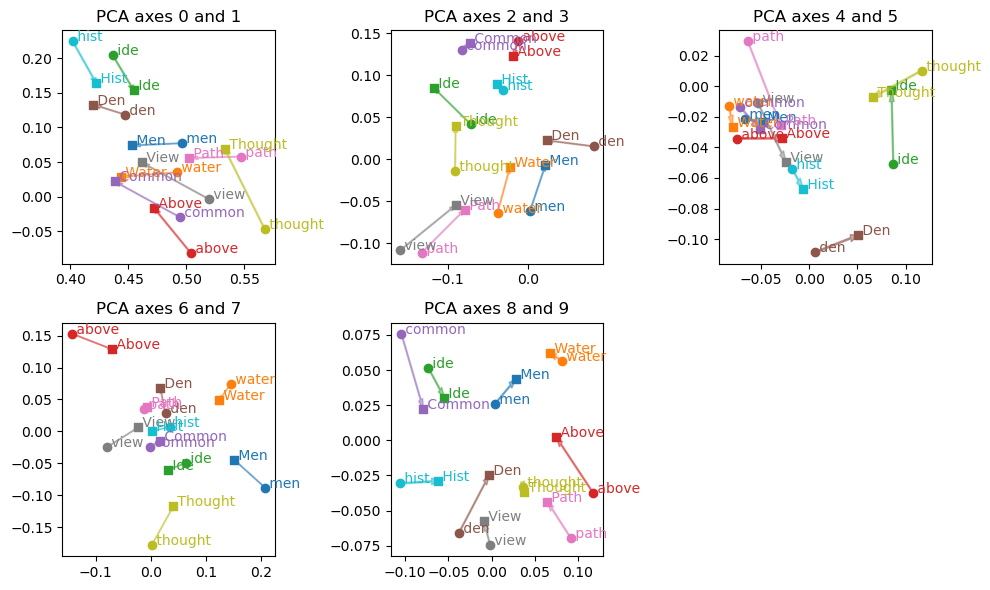

In [59]:
plt.figure(figsize=(10, 6))
i01s = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
for k, (i0, i1) in enumerate(i01s):
    plt.subplot(2, 3, k+1)
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'] # (C0, C1, ...)
    with torch.no_grad():
        for i, (token_id, capitalized_id) in enumerate(definitely_word_pairs[400:410]):
            token = tokenizer.decode([token_id])
            capitalized = tokenizer.decode([capitalized_id])
            token_embedding = pca.transform(embeddings[token_id].unsqueeze(0))[0]
            capitalized_embedding = pca.transform(embeddings[capitalized_id].unsqueeze(0))[0]
            plt.scatter(token_embedding[i0], token_embedding[i1], c=colors[i%10], marker='o')
            plt.annotate(token, (token_embedding[i0], token_embedding[i1]), c=colors[i%10])
            plt.scatter(capitalized_embedding[i0], capitalized_embedding[i1], c=colors[i%10], marker='s')
            plt.annotate(capitalized, (capitalized_embedding[i0], capitalized_embedding[i1]), c=colors[i%10])
            plt.arrow(token_embedding[i0], token_embedding[i1], 
                    capitalized_embedding[i0] - token_embedding[i0], 
                    capitalized_embedding[i1] - token_embedding[i1], 
                    length_includes_head=True,
                    head_width=0.005,
                    color=colors[i%10], alpha=0.5)
            plt.title("PCA axes {} and {}".format(i0, i1))
plt.tight_layout()

 population ->  Population
 decision ->  Decision
 himself ->  Himself
 network ->  Network
 relationship ->  Relationship
 application ->  Application
 experience ->  Experience
 below ->  Below
 money ->  Money
 help ->  Help


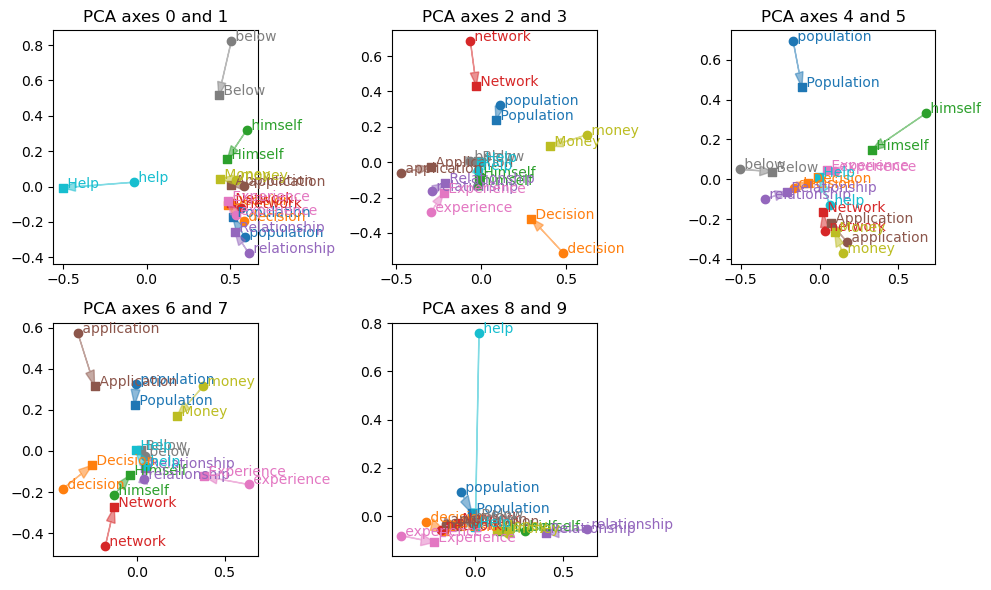

In [66]:
# hand-chosen pairs
handchosen_pair_idxs = [999, 996, 977, 975, 959, 940, 894, 863, 825, 379]
handchosen_pairs = [token_and_capitalized[i] for i in handchosen_pair_idxs]
for token, capitalized in handchosen_pairs:
    print(tokenizer.decode([token]), "->", tokenizer.decode([capitalized]))

# perform a PCA on 2N of the embeddings
with torch.no_grad():
    embeddings_pairs = torch.zeros((2*len(handchosen_pairs), embeddings.shape[1]))
    for i, (token_id, captalized_id) in enumerate(handchosen_pairs):
        embeddings_pairs[2*i] = embeddings[token_id]
        embeddings_pairs[2*i+1] = embeddings[capitalized_id]
    embeddings_pairs = embeddings_pairs.numpy()

pca = PCA(n_components=10)
pca.fit(embeddings_pairs)

plt.figure(figsize=(10, 6))
i01s = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
for k, (i0, i1) in enumerate(i01s):
    plt.subplot(2, 3, k+1)
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'] # (C0, C1, ...)
    with torch.no_grad():
        for i, (token_id, capitalized_id) in enumerate(handchosen_pairs):
            token = tokenizer.decode([token_id])
            capitalized = tokenizer.decode([capitalized_id])
            token_embedding = pca.transform(embeddings[token_id].unsqueeze(0))[0]
            capitalized_embedding = pca.transform(embeddings[capitalized_id].unsqueeze(0))[0]
            plt.scatter(token_embedding[i0], token_embedding[i1], c=colors[i%10], marker='o')
            plt.annotate(token, (token_embedding[i0], token_embedding[i1]), c=colors[i%10])
            plt.scatter(capitalized_embedding[i0], capitalized_embedding[i1], c=colors[i%10], marker='s')
            plt.annotate(capitalized, (capitalized_embedding[i0], capitalized_embedding[i1]), c=colors[i%10])
            plt.arrow(token_embedding[i0], token_embedding[i1], 
                    capitalized_embedding[i0] - token_embedding[i0], 
                    capitalized_embedding[i1] - token_embedding[i1], 
                    length_includes_head=True,
                    head_width=0.05,
                    color=colors[i%10], alpha=0.5)
            plt.title("PCA axes {} and {}".format(i0, i1))
plt.tight_layout()

In [76]:
# perform SVD on just a couple of the embeddings
with torch.no_grad():
    token_id, capitalized_id = handchosen_pairs[0]
    d0 = embeddings[capitalized_id] - embeddings[token_id]
    token_id1, capitalized_id1 = handchosen_pairs[1]
    d1 = embeddings[capitalized_id1] - embeddings[token_id]
    matrix = torch.stack([d0, d1], dim=0)
    u, s, v = torch.svd(matrix)

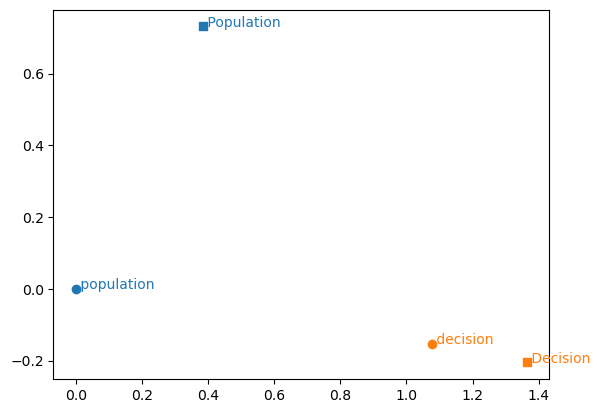

In [96]:
with torch.no_grad():
    token_id, capitalized_id = handchosen_pairs[0]
    p0 = (embeddings[token_id] - embeddings[token_id]) @ v
    p1 = (embeddings[capitalized_id] - embeddings[token_id]) @ v
    token_id1, capitalized_id1 = handchosen_pairs[1]
    p2 = (embeddings[token_id1] - embeddings[token_id]) @ v
    p3 = (embeddings[capitalized_id1] - embeddings[token_id]) @ v
    plt.scatter([p0[0]], [p0[1]], c='C0', marker='o')
    plt.annotate(tokenizer.decode([token_id]), (p0[0], p0[1]), c='C0')
    plt.scatter([p1[0]], [p1[1]], c='C0', marker='s')
    plt.annotate(tokenizer.decode([capitalized_id]), (p1[0], p1[1]), c='C0')
    plt.scatter([p2[0]], [p2[1]], c='C1', marker='o')
    plt.annotate(tokenizer.decode([token_id1]), (p2[0], p2[1]), c='C1')
    plt.scatter([p3[0]], [p3[1]], c='C1', marker='s')
    plt.annotate(tokenizer.decode([capitalized_id1]), (p3[0], p3[1]), c='C1')

In [61]:
for i in range(1000):
    token_id, capitalized_id = token_and_capitalized[i]
    token = tokenizer.decode([token_id])
    capitalized = tokenizer.decode([capitalized_id])
    print(i, token, "->", capitalized)

0  t ->  T
1  a ->  A
2  the ->  The
3  s ->  S
4  o ->  O
5  w ->  W
6  c ->  C
7  p ->  P
8  f ->  F
9  b ->  B
10  an ->  An
11  of ->  Of
12  in ->  In
13  d ->  D
14  m ->  M
15  to ->  To
16  and ->  And
17  h ->  H
18  th ->  Th
19  re ->  Re
20  n ->  N
21  l ->  L
22  e ->  E
23  g ->  G
24  is ->  Is
25  be ->  Be
26  for ->  For
27  that ->  That
28  on ->  On
29  st ->  St
30  y ->  Y
31  with ->  With
32  he ->  He
33  con ->  Con
34  as ->  As
35  it ->  It
36  pro ->  Pro
37  al ->  Al
38  we ->  We
39  v ->  V
40  wh ->  Wh
41  you ->  You
42  was ->  Was
43  de ->  De
44  ex ->  Ex
45  at ->  At
46  com ->  Com
47  or ->  Or
48  r ->  R
49  se ->  Se
50  su ->  Su
51  are ->  Are
52  by ->  By
53  not ->  Not
54  ha ->  Ha
55  ne ->  Ne
56  from ->  From
57  this ->  This
58  sh ->  Sh
59  un ->  Un
60  us ->  Us
61  ch ->  Ch
62  have ->  Have
63  le ->  Le
64  k ->  K
65  can ->  Can
66  me ->  Me
67  j ->  J
68  whe ->  Whe
69  ab ->  Ab
70  tr ->  Tr
71  were ->  W

In [123]:
i = 106
print(tokenizer.decode([token_and_capitalized[i][0]]), "->", tokenizer.decode([token_and_capitalized[i][1]]))

 app ->  App


In [ ]:
indices = [100, 102, 103, ]

In [58]:
# perform PCA on embeddings difference for N pairs of tokens
N = 500
diff_vectors = torch.zeros((N, embeddings.shape[1]))
for i, (token_id, capitalized_id) in enumerate(token_and_capitalized[:N]):
    diff_vectors[i] = embeddings[capitalized_id] - embeddings[token_id]


In [ ]:
pca = PCA(n_components=2)
pca.fit(diff_vectors)

In [126]:
os.getenv("OPENAI_API_KEY")